In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Convolution1D,BatchNormalization,concatenate,Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
import sys
from collections import Counter

import numpy as np
import tensorflow.keras as kr

if sys.version_info[0] > 2:
    is_py3 = True
else:
    reload(sys)
    sys.setdefaultencoding("utf-8")
    is_py3 = False


def native_word(word, encoding='utf-8'):
    """如果在python2下面使用python3训练的模型，可考虑调用此函数转化一下字符编码"""
    if not is_py3:
        return word.encode(encoding)
    else:
        return word


def native_content(content):
    if not is_py3:
        return content.decode('utf-8')
    else:
        return content


def open_file(filename, mode='r'):
    """
    常用文件操作，可在python2和python3间切换.
    mode: 'r' or 'w' for read or write
    """
    if is_py3:
        return open(filename, mode, encoding='utf-8', errors='ignore')
    else:
        return open(filename, mode)


def read_file(filename):
    """读取文件数据"""
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(native_content(content)))
                    labels.append(native_content(label))
            except:
                pass
    return contents, labels


def build_vocab(train_dir, vocab_dir, vocab_size=5000):
    """根据训练集构建词汇表，存储"""
    data_train, _ = read_file(train_dir)

    all_data = []
    for content in data_train:
        all_data.extend(content)

    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open_file(vocab_dir, mode='w').write('\n'.join(words) + '\n')


def read_vocab(vocab_dir):
    """读取词汇表"""
    with open_file(vocab_dir) as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [native_content(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id


def read_category():
    """读取分类目录，固定"""
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']

    categories = [native_content(x) for x in categories]

    cat_to_id = dict(zip(categories, range(len(categories))))

    return categories, cat_to_id


def to_words(content, words):
    """将id表示的内容转换为文字"""
    return ''.join(words[x] for x in content)


def process_file(filename, word_to_id, cat_to_id, max_length=600):
    """将文件转换为id表示"""
    contents, labels = read_file(filename)

    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])
        label_id.append(cat_to_id[labels[i]])

    # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示

    return x_pad, y_pad


def batch_iter(x, y, batch_size=64):
    """生成批次数据"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]

In [5]:
train_dir = 'cnews.train.txt'
test_dir = 'cnews.test.txt'
val_dir = 'cnews.val.txt'
vocab_dir = 'cnews.vocab.txt'
save_dir = 'checkpoints/textcnn'
save_path = 'best_validation'

In [6]:
if not os.path.exists(vocab_dir):  # 如果不存在词汇表，重建
    build_vocab(train_dir, vocab_dir, config.vocab_size)

In [7]:
# 创建数据类别映射、文本字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_dir)
vocab_size = len(words)

In [73]:
seq_length = 600  # 序列长度
x_train, y_train = process_file(train_dir, word_to_id, cat_to_id, seq_length)
x_val, y_val = process_file(val_dir, word_to_id, cat_to_id, seq_length)

In [74]:
#TextInception
# main_input = Input(shape=(600,), dtype='float64')
# embedder = Embedding(vocab_size + 1, 256, input_length = 600)
# embed = embedder(main_input)
# block1 = Convolution1D(128, 1, padding='same')(embed)
# conv2_1 = Convolution1D(256, 1, padding='same')(embed)
# bn2_1 = BatchNormalization()(conv2_1)
# relu2_1 = Activation('relu')(bn2_1)
# block2 = Convolution1D(128, 3, padding='same')(relu2_1)
# inception = concatenate([block1, block2], axis=-1)
# flat = Flatten()(inception)
# fc = Dense(128)(flat)
# drop = Dropout(0.5)(fc)
# bn = BatchNormalization()(drop)
# relu = Activation('relu')(bn)
# main_output = Dense(10, activation='softmax')(relu)
# model = Model(inputs = main_input, outputs = main_output)
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
main_input = Input(shape=(600,), dtype='float64')
embedder = Embedding(vocab_size + 1, 256, input_length = 600)
embed = embedder(main_input)
conv2_1 = Convolution1D(128, 1, padding='same')(embed)
bn2_1 = BatchNormalization()(conv2_1)
relu2_1 = Activation('relu')(bn2_1)
conv2_2 = Convolution1D(128, 3, padding='same')(relu2_1)
flat = Flatten()(conv2_2)
fc = Dense(128)(flat)
drop = Dropout(0.5)(fc)
bn = BatchNormalization()(drop)
relu = Activation('relu')(bn)
main_output = Dense(10, activation='softmax')(relu)
model = Model(inputs = main_input, outputs = main_output)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 256)          1280256   
                                                                 
 conv1d (Conv1D)             (None, 600, 128)          32896     
                                                                 
 batch_normalization (BatchN  (None, 600, 128)         512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 600, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 600, 128)          49280     
                                                             

In [76]:
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=3,
          validation_data=(x_val, y_val))

Epoch 1/3
1563/1563 [==============================] - 139s 78ms/step - loss: 0.3613 - accuracy: 0.8956 - val_loss: 0.5181 - val_accuracy: 0.8556
Epoch 2/3
1563/1563 [==============================] - 30s 19ms/step - loss: 0.1331 - accuracy: 0.9614 - val_loss: 0.4725 - val_accuracy: 0.8848
Epoch 3/3
1563/1563 [==============================] - 32s 21ms/step - loss: 0.0902 - accuracy: 0.9723 - val_loss: 0.4052 - val_accuracy: 0.9034


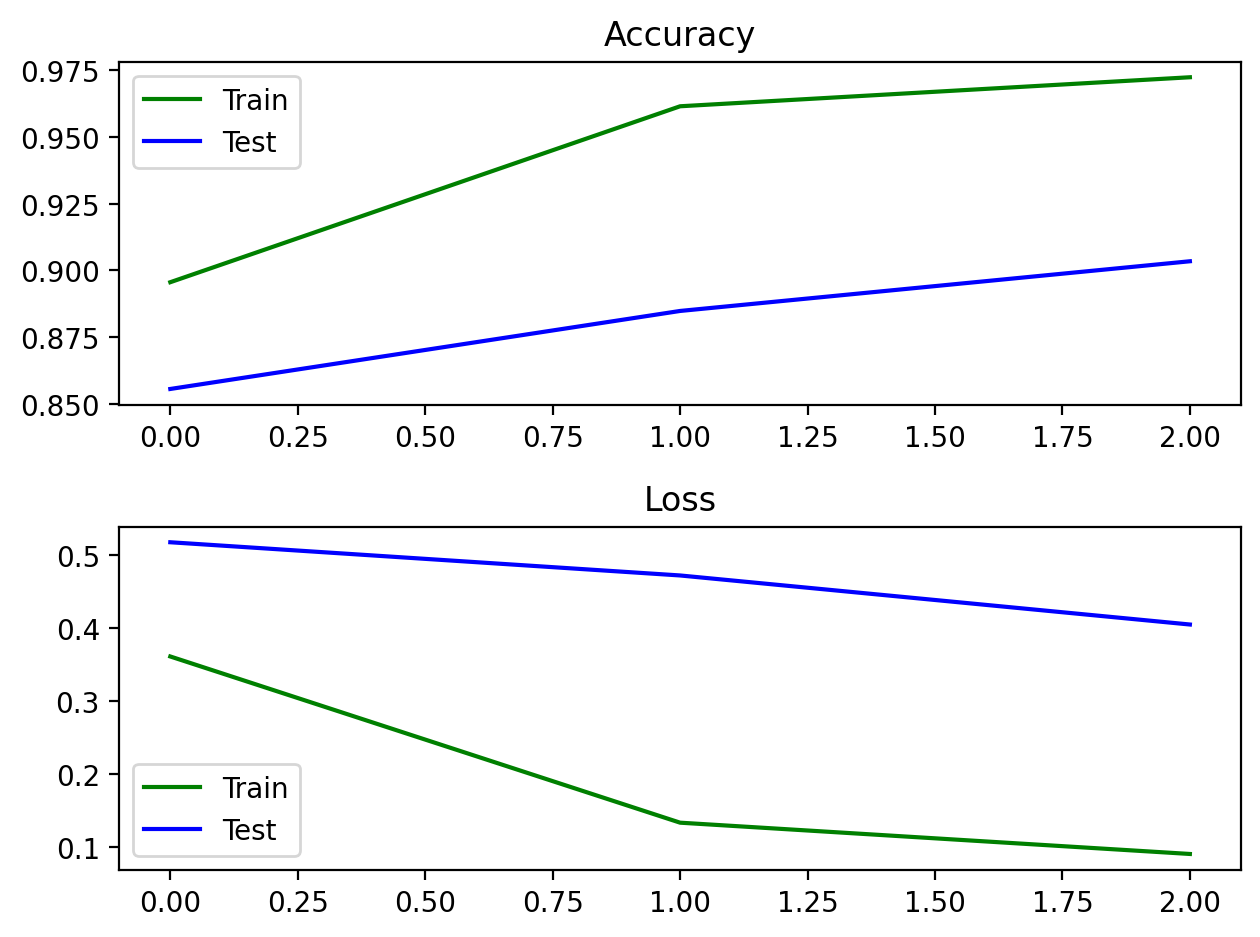

In [77]:
# plot accuracy and loss
def plot_acc_loss(history):
    plt.subplot(211)
    plt.title("Accuracy")
    plt.plot(history.history["accuracy"], color="g", label="Train")
    plt.plot(history.history["val_accuracy"], color="b", label="Test")
    plt.legend(loc="best")
    
    plt.subplot(212)
    plt.title("Loss")
    plt.plot(history.history["loss"], color="g", label="Train")
    plt.plot(history.history["val_loss"], color="b", label="Test")
    plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()
plot_acc_loss(history)

In [78]:
## 模型的保存和导入
from keras.models import load_model
# 保存模型
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir,'my_model1.h5'))
del model  # deletes the existing model

In [79]:
# 导入已经训练好的模型
from keras.models import load_model
model1 = load_model(os.path.join(save_dir,'my_model1.h5'))

In [84]:
## 对测试集进行预测
y_pre = model1.predict(x_val)

157/157 [==============================] - 1s 5ms/step


[[9.99999523e-01 5.14970555e-09 7.45459232e-08 ... 1.05733449e-08
  2.97491329e-08 1.27069583e-07]
 [9.99641061e-01 4.01240686e-06 1.79771632e-07 ... 5.90070250e-08
  3.52832176e-05 1.62576805e-06]
 [9.99990106e-01 4.99658181e-09 3.94122395e-07 ... 2.74232609e-10
  8.72324472e-06 7.05523917e-07]
 ...
 [2.74289258e-09 9.99999642e-01 1.03526343e-08 ... 5.83599391e-09
  3.21753091e-09 1.23698143e-07]
 [1.02219300e-03 9.55222011e-01 1.11564932e-05 ... 2.41120160e-03
  1.03101069e-04 1.39913420e-04]
 [8.62272088e-07 9.99952912e-01 3.76695908e-07 ... 1.22376705e-05
  1.67421362e-07 6.82234759e-06]]


C:\Users\lutin\.conda\envs\TensorGPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lutin\.conda\envs\TensorGPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lutin\.conda\envs\TensorGPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36130 (\N{CJK UNIFIED IDEOGRAPH-8D22}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lutin\.conda\envs\TensorGPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lutin\.conda\envs\TensorGPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F})

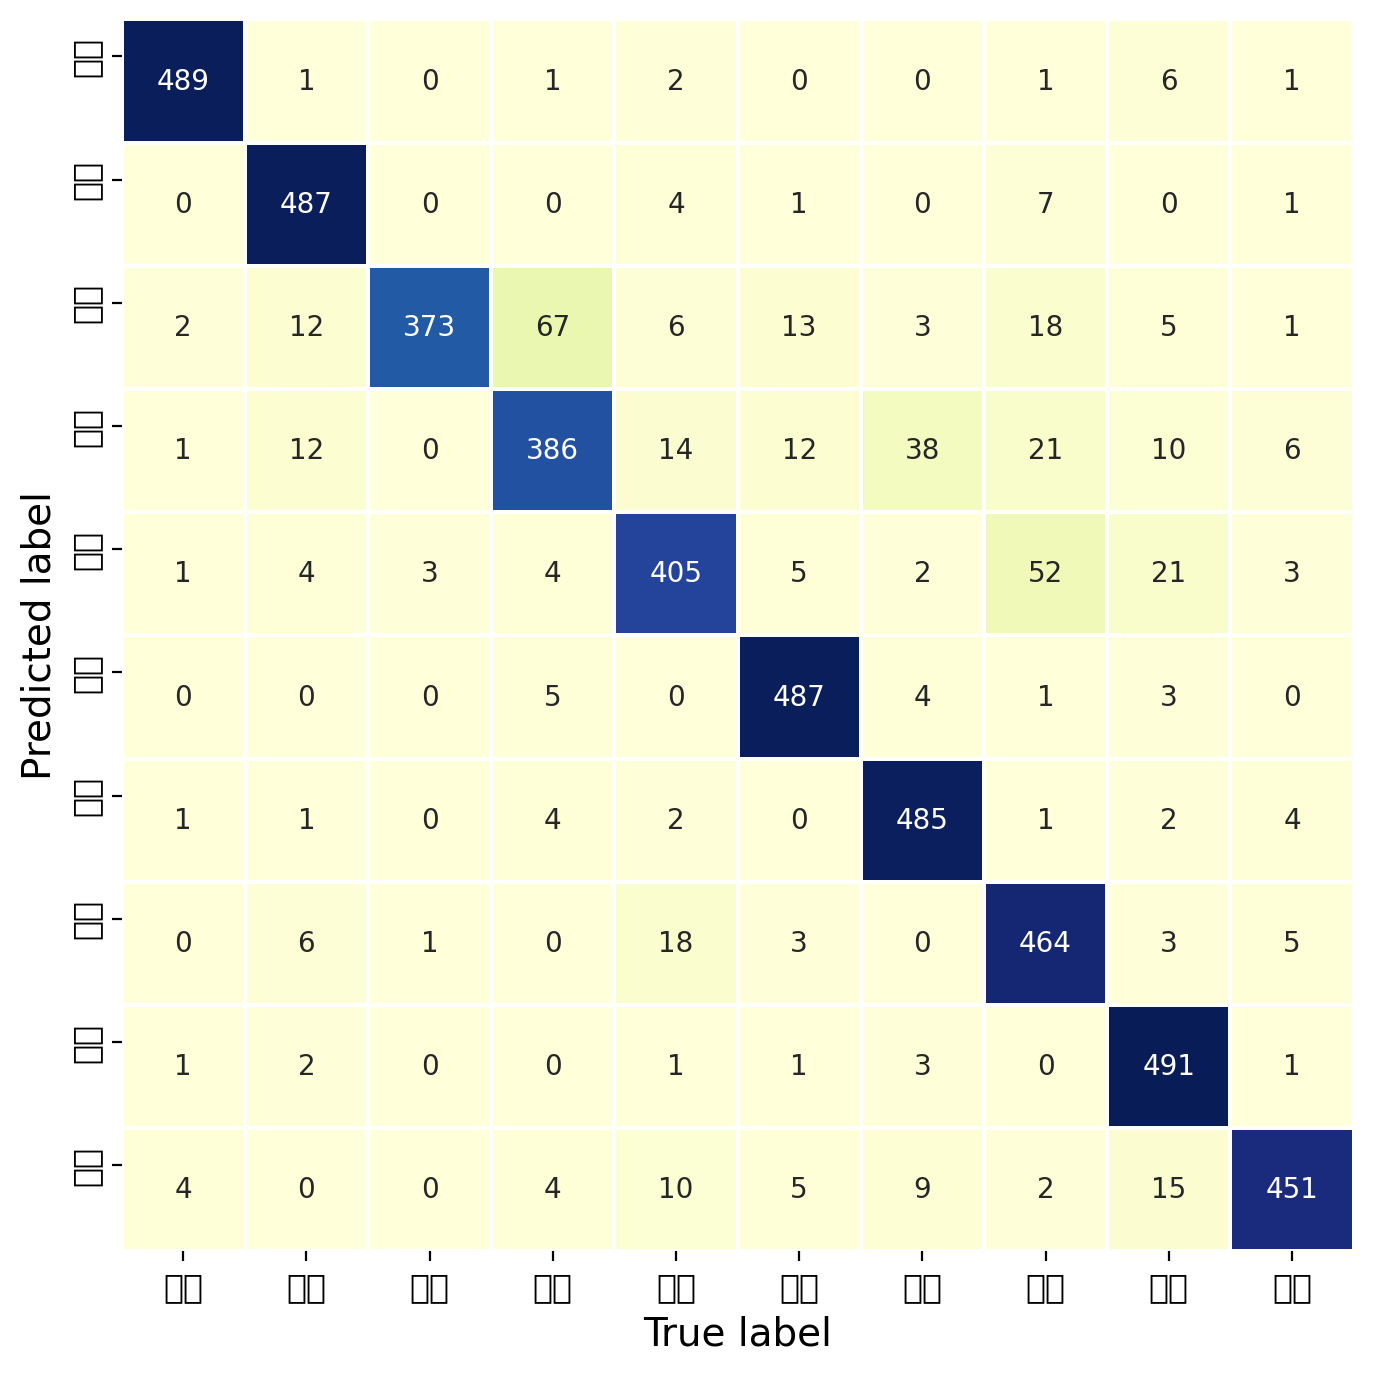

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       499
           1       0.97      0.93      0.95       525
           2       0.75      0.99      0.85       377
           3       0.77      0.82      0.80       471
           4       0.81      0.88      0.84       462
           5       0.97      0.92      0.95       527
           6       0.97      0.89      0.93       544
           7       0.93      0.82      0.87       567
           8       0.98      0.88      0.93       556
           9       0.90      0.95      0.93       473

    accuracy                           0.90      5001
   macro avg       0.90      0.91      0.90      5001
weighted avg       0.91      0.90      0.90      5001



In [85]:
print(y_pre)
## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_pre,axis=1),np.argmax(y_val,axis=1))
## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(10)+0.5,categories,size = 12)
plt.yticks(np.arange(10)+0.3,categories,
size = 12)
plt.show()


print(metrics.classification_report(np.argmax(y_pre,axis=1),np.argmax(y_val,axis=1)))

In [80]:
test="我国用于载人登月的新一代载人火箭将于2030年前完成研制。“2030年前”这个时间让人心潮澎湃，更心怀期待。为能将中国人的脚印留在月球，无数航天人一步一个脚印，扎扎实实地推进着技术攻关。“仰望星空，脚踏实地”，这八个字特别适合中国航天。我们的目标是"

In [81]:
data_id=[]
data_id.append([word_to_id[x] for x in test if x in word_to_id])
# 使用keras提供的pad_sequences来将文本pad为固定长度
x_pad = kr.preprocessing.sequence.pad_sequences(data_id, 600)

In [82]:
y_pre = model1.predict(x_pad)

1/1 [==============================] - 0s 360ms/step


In [83]:
y_pres=y_pre.tolist()

keys=list(cat_to_id.keys())

for pre in y_pres:
    result={}
    for i in range(10):
        result[keys[i]]=pre[i]
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    print(result)

[('时尚', 0.27345821261405945), ('时政', 0.2260284572839737), ('科技', 0.18820235133171082), ('游戏', 0.14409953355789185), ('家居', 0.06169718876481056), ('教育', 0.048951540142297745), ('娱乐', 0.037477027624845505), ('体育', 0.01368797942996025), ('财经', 0.005309356842190027), ('房产', 0.0010883485665544868)]
